In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# Moving Average

#### Goal
Forecast values from errors of past predictions (e.g. $\phi$ * $e_{t-1}$) --> from lagged errors and the current error $e_t$

#### Formula
$Y_t$ = $w$ + $\phi$ $e_{t-1}$ + $e_t$, where  𝑤 is the intercept

#### In General
Shocks of past observations have no except if they happened long enough ago. Depending on the number of lags. Therefore, MA models are short term memory models.

### Excursion: Stationarity

In [2]:
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


<AxesSubplot:xlabel='Month'>

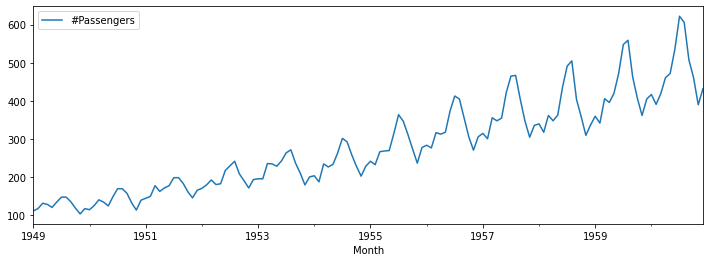

In [3]:
df.plot(x='Month',y='#Passengers',figsize=(12,4))

### Not stationary: long term trend and seasonality visible

### Make data stationary with Differencing

In [4]:
df['Passenger_Diff'] = df['#Passengers'].diff()

<AxesSubplot:xlabel='Month'>

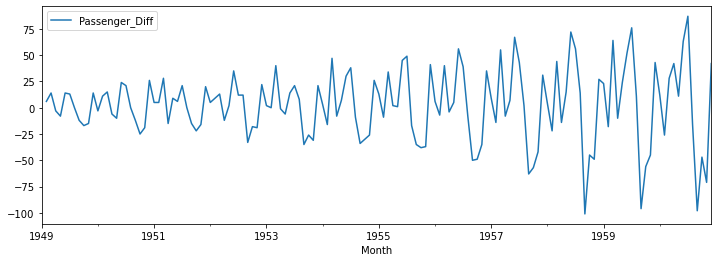

In [5]:
df.plot(x='Month',y='Passenger_Diff',figsize=(12,4))

### Mean is now constant and data is distributed around 0. However, variance is still increasing

In [6]:
df['Passenger_Log'] = np.log(df['#Passengers'])

### Logarithmic transform data to get a consistent scale. However, there is still a trend. Therefore we add the difference transform.

In [7]:
df['Passenger_Diff_Log'] = df['Passenger_Log'].diff()

<AxesSubplot:xlabel='Month'>

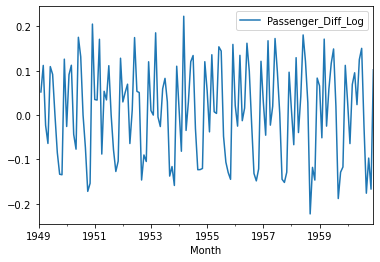

In [8]:
df.plot(x='Month', y='Passenger_Diff_Log')

### Finally, data is stationary from a visual point of view.

### Lets conduct the Augmented Dickey-Fuller (ADF) Test with statsmodels package.

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    adf = adfuller(series.dropna())
    print('ADF Statistic: ', adf[0])
    print('P-Value: ', adf[1])
    print('Critical Values: ')
    for thres, adf_stat in adf[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))
    

In [10]:
print('ADF Test before log transform')
adf_test(df['Passenger_Diff'])

ADF Test before log transform
ADF Statistic:  -2.8292668241699945
P-Value:  0.05421329028382621
Critical Values: 
	1%: -3.48
	5%: -2.88
	10%: -2.58


In [11]:
print('ADF Test after log transform')
adf_test(df['Passenger_Diff_Log'])

ADF Test after log transform
ADF Statistic:  -2.7171305983881138
P-Value:  0.07112054815086194
Critical Values: 
	1%: -3.48
	5%: -2.88
	10%: -2.58


### Make data stationary with Box-Conn Transform
#### With the log-transform, it is assumed that data follows a exponential trend, thus natural logarithm is not always the best choice to make data stationary.
#### With the box-conn transform, it is evaluated wheter the natural log is the best transform or some other power transformation is more optimal.
Transform non-normal data to more normal distribution like data.

#### 0 --> Natural Log
#### 1 --> No transform
#### 3 --> Cubic

In [12]:
from scipy.stats import boxcox

df['Passengers_Boxcox'], lam = boxcox(df['#Passengers'])

<AxesSubplot:xlabel='Month'>

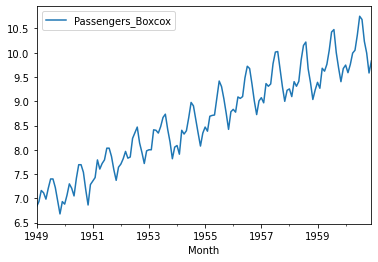

In [13]:
df.plot(x='Month', y='Passengers_Boxcox')

In [14]:
print('Lambada close to 0, e.g. nautral log trasnform: ', lam)

Lambada close to 0, e.g. nautral log trasnform:  0.14802265137037945


<AxesSubplot:xlabel='Month'>

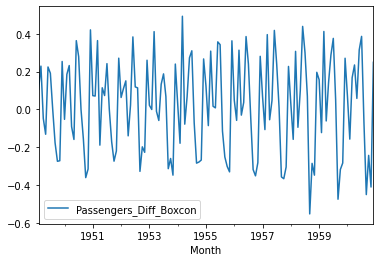

In [15]:
df['Passengers_Diff_Boxcon'] = df['Passengers_Boxcox'].diff()
df.dropna(inplace=True)

df.plot(x='Month', y='Passengers_Diff_Boxcon')

In [16]:
print('ADF Test after Boxcon transform')
adf_test(df['Passengers_Diff_Boxcon'])

ADF Test after Boxcon transform
ADF Statistic:  -2.8717075283174176
P-Value:  0.04873833392661521
Critical Values: 
	1%: -3.48
	5%: -2.88
	10%: -2.58


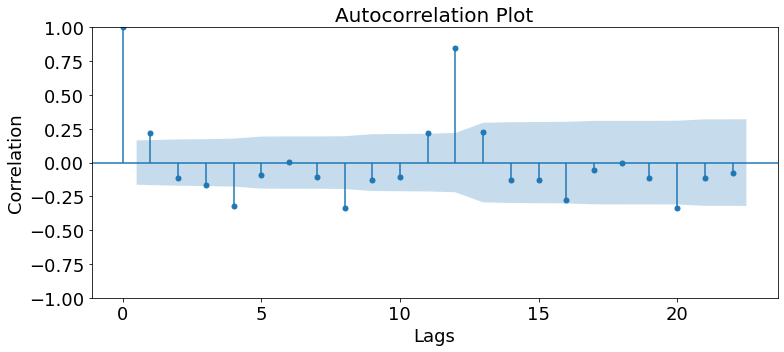

In [17]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation
plt.rc("figure", figsize=(11,5))
plot_acf(df['Passengers_Diff_Boxcon'])
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

1. There is a cyclical pattern at every mutliple of 12 --> e.g. months, yearly seasonality
2. Blue area: Depicts the 95% confidence interval and is an indicator of the significance threshold: Anything within is statistically close to zero, everything outside (on white) is statistically non-zero. Non-zero means non-random --> lag is important to look at.
3. For Lags that are outside the blue area you may say that with 95% probability those lags have an impact on values

#### Example: 
1. Lag 1 has a correlation of around 0.25. This means the following data point is described in 25% by previous value.
2. Lag 12 has a correlation of around 0.8. This means that current data will impact data in 12 months by 80%.

Negative correlations:
1. A negative autocorrelation implies that if a past value is above average, the newer value is more likely to be below average (or vice versa).
2. Example: If we observe above average passengers this month, we might say that with 10% probability, in 40 month we would observe less passengers than on average.



In [18]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA

# Split train and test
train = df.iloc[:-int(len(df) * 0.2)]
test = df.iloc[-int(len(df) * 0.2):]

# Train model
model = ARIMA(train['Passengers_Diff_Boxcon'], order=(0, 0, 13)).fit()

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-package

In [20]:
# Get forecasts predicted by model
transformed_forecasts = list(model.forecast(steps=len(test)))

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [32]:
transformed_forecasts

[-0.07589279322363855,
 -0.062072629656436173,
 -0.21524774981423772,
 0.04887135130441461,
 -0.005910078173135887,
 -0.1172810109504918,
 0.09117188909354174,
 -0.08883365426077544,
 -0.040921988728288256,
 0.15015998040765763,
 0.08021437792051714,
 0.03763298534118087,
 0.034139012004290474,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759,
 0.02447653398767759]

In [35]:
# Transform to actual passenger volume 
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Passengers_Boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)
    
from scipy.special import inv_boxcox

forecasts = inv_boxcox(boxcox_forecasts, lam)

In [36]:
# Plot result
import plotly.graph_objects as go
import os

def plot_forecasts(forecasts: list[float], title: str, save_path: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    if not os.path.exists("../images"):
        os.mkdir("../images")

    fig.write_image("../images/" + str(save_path))
    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Moving Average Model', 'result.png')

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



#### The plot shows that the model identified the trend but not the seasonality

In [37]:
# Calculate MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(test['#Passengers'],forecasts)

7018.592349287064

# Autoregressive Model

#### Goal
Forecast depends solely on the past values in the series called lags: $\phi$ * $y_{t-1}$

#### Formula
$Y_t$ = $w$ + $\phi$ $y_{t-1}$ + $e_t$, where $w$ is the intercept and $\phi$ the fitted coefficients

#### In General
1. AR is a recursive model, which means a prediction depends on all past values --> Long term memory. However, observations far away do not impact the predictions as much as more recent observations.
2. Forecast a time series using some linear weighted combination of the previous values (lags).
3. REgress the target value against itself, it is called auto-regression.

In [63]:
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [64]:
data['Passengers_Boxcox'], lam2 = boxcox(data['#Passengers'])
data['Passenger_stationary'] = data['Passengers_Boxcox'].diff()
data.dropna(inplace=True)

<AxesSubplot:xlabel='Month'>

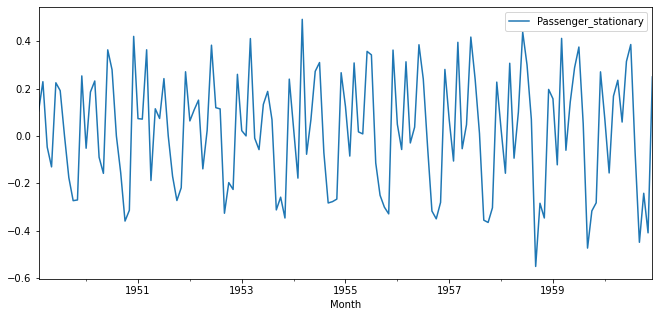

In [65]:
data.plot(x='Month', y='Passenger_stationary')

In [66]:
adf_test(data['Passenger_stationary'])

ADF Statistic:  -2.8717075283174176
P-Value:  0.04873833392661521
Critical Values: 
	1%: -3.48
	5%: -2.88
	10%: -2.58


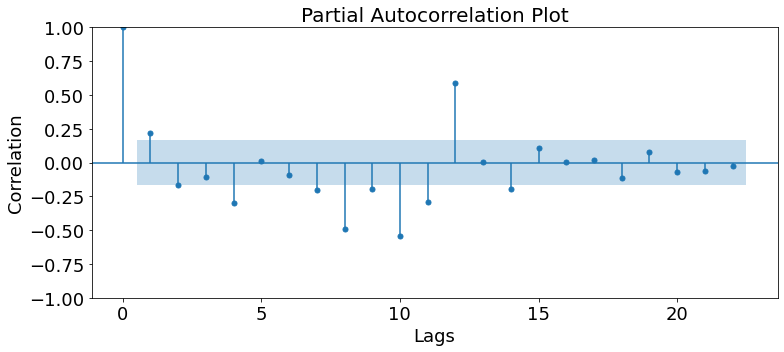

In [67]:
# Plot partial autocorrelation
plt.rc("figure", figsize=(11,5))
plot_pacf(data['Passenger_stationary'].dropna(), method='ywm')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

#### Lags 1,2,4,7,8,9,10,11,12,14 seem to be important.
However, since the dataset is small, we can iterate over all the possible lag combinations and choose the best performing model:

In [68]:
# Import packages
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Build AR model
selector = ar_select_order(train['Passenger_stationary'], 15)
model = AutoReg(train['Passenger_stationary'], lags=selector.ar_lags).fit()

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [70]:
# Import packages
from scipy.special import inv_boxcox
import plotly.graph_objects as go

# Get forecasts and convert to actual passenger volumes
transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Passengers_Boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Autoregression')

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



### Trend and seasonality adequatly caputred by the model

However, the seasonality was captured, as a result of the model having an order (lags) of 13 --> all lags in past year included to forecast.

In [75]:
print('Selected lags:')
selector.ar_lags

Selected lags:


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [71]:
# Calculate MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(test['#Passengers'],forecasts)

745.5757572929427

# ARIMA

#### Goal
Combine AR and MA models with typically fewer terms but model great as well.

#### Selection Techniques
How many lags should I select for AR and MA models.

#### Integrated I
The I stands for integrated: The number (order) of differencing required to make data stationary.

#### Combined Formula
$y'_t$ = c + $\phi_1 y'_{t-1} + ... + \phi_p y'_{t-p} + e_t + \sigma_1 e_1 + ... + \sigma_q e_{t-q}$ ,

where y' refers to the differenced version of the time series.

<AxesSubplot:xlabel='Month'>

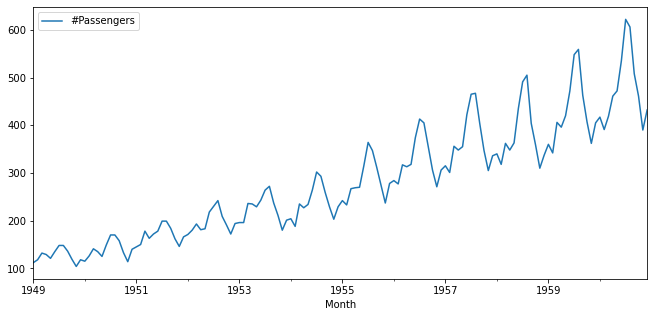

In [88]:
# Read in the data
data_arima = pd.read_csv('AirPassengers.csv')
data_arima['Month'] = pd.to_datetime(data_arima['Month'])

data_arima.plot(x='Month',y='#Passengers')

<AxesSubplot:xlabel='Month'>

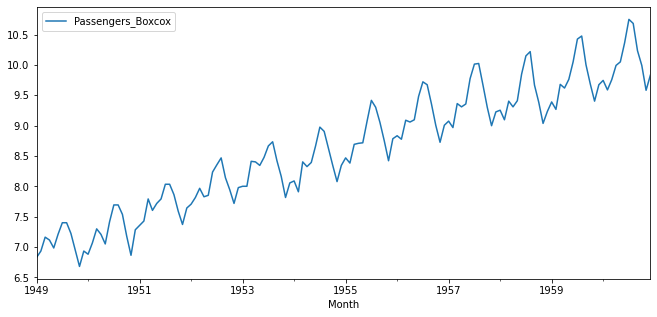

In [89]:
# Import packages 
from scipy.stats import boxcox

# Make the target variance stationary
data_arima['Passengers_Boxcox'], lam = boxcox(data_arima['#Passengers'])

data_arima.plot(x='Month',y='Passengers_Boxcox')

#### Data still has a positive trend, but the seasonal fluctuations are now consistent

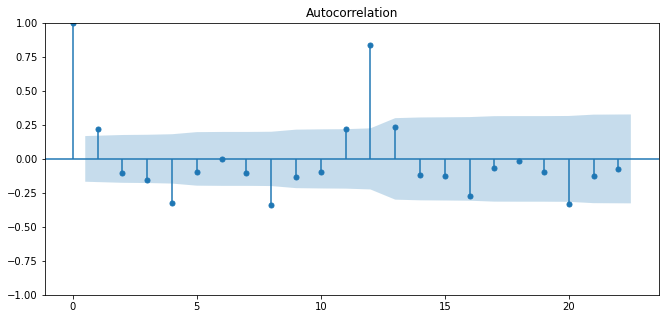

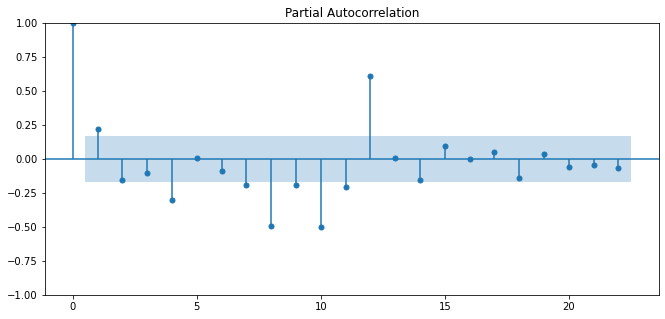

In [98]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Difference the data
data_arima["Passenger_diff"] = data_arima["Passengers_Boxcox"].diff()
data_arima.dropna(inplace=True)

# Plot acf and pacf
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(data_arima['Passenger_diff'])
plot_pacf(data_arima['Passenger_diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
#plt.show()

#### For the MA part, lags 1, 4, 8, 11, 12, 20 seem to be relevant // for the AR part, lags 1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 15 seem to be relevant

#### However, since the dataset is small, we could grid-search the best combination

In [103]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox

# Split train and test
train = data_arima.iloc[:-int(len(data_arima) * 0.2)]
test = data_arima.iloc[-int(len(data_arima) * 0.2):]

# Build ARIMA model and inverse the boxcox
model = ARIMA(train['Passengers_Boxcox'], order=(15, 1, 20)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting pa

In [104]:
# Import packages
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'ARIMA')

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [105]:
# Calculate MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(test['#Passengers'],forecasts)

962.9226681306259